### Feature engineering

Librerías datos y gráficos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option("max_colwidth", 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('data/df_total.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
'''Eliminación de columnas irrelevantes'''

df = df.drop(['thumbnail','numPhotos','operation','province','has360','country','url','hasVideo','hasPlan','has3DTour','hasStaging','externalReference','labels','newDevelopmentFinished','highlight'],axis=1)
df = df.drop(['topNewDevelopment','superTopHighlight'], axis=1)

In [6]:
'''eliminacion de registros con anomalías'''

df = df.drop([874,543,546,545,547,515,802,210,261,992])

In [7]:
'''reinicio de indices para no tener problema con las llamadas'''
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)

In [8]:
'''creo una columna binaria de parking donde 0, es que no hay parking incluido en el precio
y 1, el parking está incluido en el precio.
Habrá un 0 por defecto.'''
df['parking'] = 0

In [9]:
'''relleno los valores null con 0, diciendo así que no hay parking'''
df['parkingSpace'] = df['parkingSpace'].fillna(0)

In [10]:
'''bucle for donde si el valor no es 0, creo una variable en la que convierto el diccionario dentro de parkingSpace,
en una string, para poder preguntarle, que si no contiene un False, me ponga un 1 en la columna parking'''
for i, dicc in enumerate(df['parkingSpace']):
    if dicc != 0:
        string = str(dicc)
        if 'False' not in string:
            df['parking'][i] = 1

In [11]:
'''relleno los valores sin distrito, con el mismo municipio'''
df['district'].fillna(df['municipality'],inplace=True)

In [12]:
'''Creo una df agrupada por municipios y dentro de estos, por distritos.
Saco la media del precio/area según este agrupamiento.
Codifico cada minicipio/distrito de menor a mayor según la media del precio/area
Creo una columna con el municipio y su distrito'''
grupo_ciudad_distrito = df.groupby(['municipality','district'],as_index=False)['priceByArea'].agg(['mean'])
grupo_ciudad_distrito = grupo_ciudad_distrito.sort_values(by='mean',ascending=True)
grupo_ciudad_distrito = grupo_ciudad_distrito.reset_index()
grupo_ciudad_distrito = grupo_ciudad_distrito.reset_index()
grupo_ciudad_distrito.drop(['index'],axis=1,inplace=True)
grupo_ciudad_distrito['level_0'] = grupo_ciudad_distrito['level_0']+1
grupo_ciudad_distrito.rename(columns={'level_0':'codigo_distrito'},inplace=True)
grupo_ciudad_distrito['poblacion / distrito'] = grupo_ciudad_distrito['municipality'] + ' / ' + grupo_ciudad_distrito['district']

In [13]:
df[['municipality','district']]

,municipality,district
0,Dos Hermanas,El Arenal - La Pólvora
1,Sevilla,Nervión
2,Sevilla,Santa Justa - Miraflores - Cruz Roja
3,Sevilla,Nervión
4,Montequinto,Condequinto
...,...,...
986,Utrera,Utrera
987,Utrera,Utrera
988,Utrera,Utrera
989,Utrera,Utrera


In [14]:
'''Añado las 3 categorias creadas a nuestra dataframe con un valor por defecto de 0'''
df['codigo_distrito'] = 0
df['poblacion / distrito'] = 0
df['precio_area / distrito'] = 0

In [15]:
'''mediante un bucle for, voy recorriendo nuestra dataframe
y comparandola con la agrupada para añadir despues los valores que correspondan
en cada columna creada'''
for i, municipio in enumerate(df['municipality']):
    if df['codigo_distrito'][i] == 0:
        for n, municipio_group in enumerate(grupo_ciudad_distrito['municipality']):
            if municipio_group == municipio:
                for w, distrito in enumerate(df['district']):
                    if w == i:
                        for p, distrito_group in enumerate(grupo_ciudad_distrito['district']):
                            if distrito_group == distrito and grupo_ciudad_distrito['municipality'][p] == municipio:
                                df['codigo_distrito'][i] = grupo_ciudad_distrito['codigo_distrito'][p]
                                df['poblacion / distrito'][i] = grupo_ciudad_distrito['poblacion / distrito'][p]
                                df['precio_area / distrito'][i] = grupo_ciudad_distrito['mean'][p]  

In [16]:
df['codigo_distrito'].nunique()

70

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            991 non-null    int64  
 1   floor                   839 non-null    object 
 2   price                   991 non-null    float64
 3   propertyType            991 non-null    object 
 4   size                    991 non-null    float64
 5   exterior                834 non-null    object 
 6   rooms                   991 non-null    int64  
 7   bathrooms               991 non-null    int64  
 8   address                 991 non-null    object 
 9   municipality            991 non-null    object 
 10  district                991 non-null    object 
 11  latitude                991 non-null    float64
 12  longitude               991 non-null    float64
 13  showAddress             991 non-null    bool   
 14  distance                991 non-null    in

In [18]:
df['detailedType'].value_counts()

detailedType
{'typology': 'flat'}                                          763
{'typology': 'chalet', 'subTypology': 'independantHouse'}      83
{'typology': 'flat', 'subTypology': 'penthouse'}               42
{'typology': 'chalet', 'subTypology': 'terracedHouse'}         34
{'typology': 'flat', 'subTypology': 'studio'}                  27
{'typology': 'flat', 'subTypology': 'duplex'}                  26
{'typology': 'chalet', 'subTypology': 'semidetachedHouse'}     13
{'typology': 'chalet'}                                          3
Name: count, dtype: int64

In [19]:
'''creamos columna para codificar el tipo de casa,
los códigos son asignados por la medias de precios de menor a mayor
- Estudio : 1
- Piso : 2
- Adosada : 3
- Duplex : 4
- Atico : 5
- Pareada : 6
- Independiente : 7
'''
df['codigo_tipo'] = 0

In [20]:
for i, tipo in enumerate(df['detailedType']):
    variable = str(tipo)
    if variable == "{'typology': 'flat', 'subTypology': 'studio'}": 
        df['codigo_tipo'][i] = 1
    elif variable == "{'typology': 'flat'}": 
        df['codigo_tipo'][i] = 2
    elif variable == "{'typology': 'chalet', 'subTypology': 'terracedHouse'}": 
        df['codigo_tipo'][i] = 3
    elif variable == "{'typology': 'flat', 'subTypology': 'duplex'}": 
        df['codigo_tipo'][i] = 4
    elif variable == "{'typology': 'flat', 'subTypology': 'penthouse'}": 
        df['codigo_tipo'][i] = 5
    elif variable == "{'typology': 'chalet', 'subTypology': 'semidetachedHouse'}": 
        df['codigo_tipo'][i] = 6
    else: 
        df['codigo_tipo'][i] = 7

In [21]:
'''intento que el bucle abarque, la falta de tildes o la palabra en mayúscula'''
for i, comment in enumerate(df['description']):
    if pd.notna(comment) and ('ático' in comment or 'atico' in comment or 'Ático' in comment or 'Atico' in comment):
        df['codigo_tipo'][i] = 5
   

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            991 non-null    int64  
 1   floor                   839 non-null    object 
 2   price                   991 non-null    float64
 3   propertyType            991 non-null    object 
 4   size                    991 non-null    float64
 5   exterior                834 non-null    object 
 6   rooms                   991 non-null    int64  
 7   bathrooms               991 non-null    int64  
 8   address                 991 non-null    object 
 9   municipality            991 non-null    object 
 10  district                991 non-null    object 
 11  latitude                991 non-null    float64
 12  longitude               991 non-null    float64
 13  showAddress             991 non-null    bool   
 14  distance                991 non-null    in

In [23]:
'''elimino columnas irrelevantes'''
df = df.drop(['municipality','address','district','showAddress','exterior','distance','suggestedTexts','neighborhood','floor','detailedType','newDevelopment','hasLift','parkingSpace'],axis=1)

In [24]:
'''creo una dataframe solo con datos númericos'''
df_num = df[['size','rooms','bathrooms','codigo_distrito','parking','price','codigo_tipo']]

In [25]:
'''creo una columna, donde unifico los baños y habitaciones,
para así evitar la multicolinealidad'''
df_num['total_rooms'] = df_num['bathrooms'] + df_num['rooms']
df_num.drop(['rooms','bathrooms'],axis=1,inplace=True)

In [26]:
'''código para pasar precio(target) al final, 
para así analizar mejor el siguiente diagrama'''
df_num = df_num[[col for col in df_num.columns if col != 'price'] + ['price']]

<Axes: >

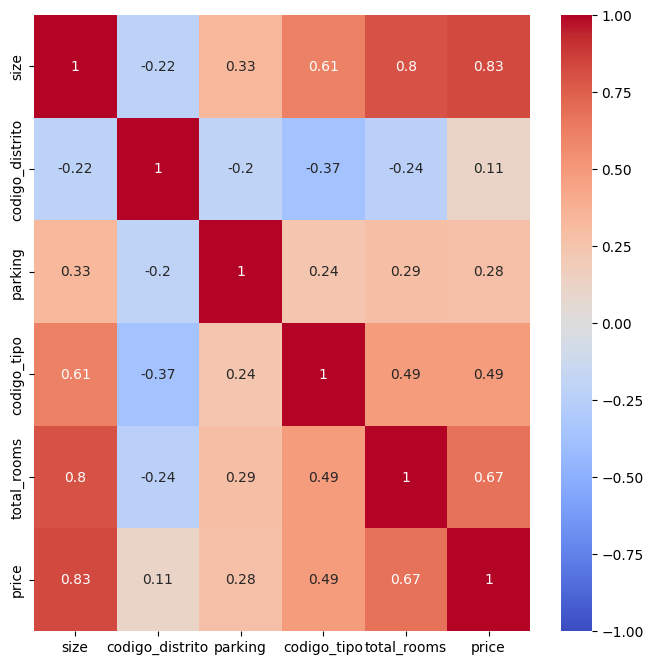

In [27]:
plt.figure(figsize=(8,8))
sns.heatmap(df_num.corr(),annot=True,vmin=-1,cmap='coolwarm')

Aún se observa multicolinealidad entre total_rooms y size, pero son 2 atributos de los que no puedo prescindir

<Figure size 800x800 with 0 Axes>

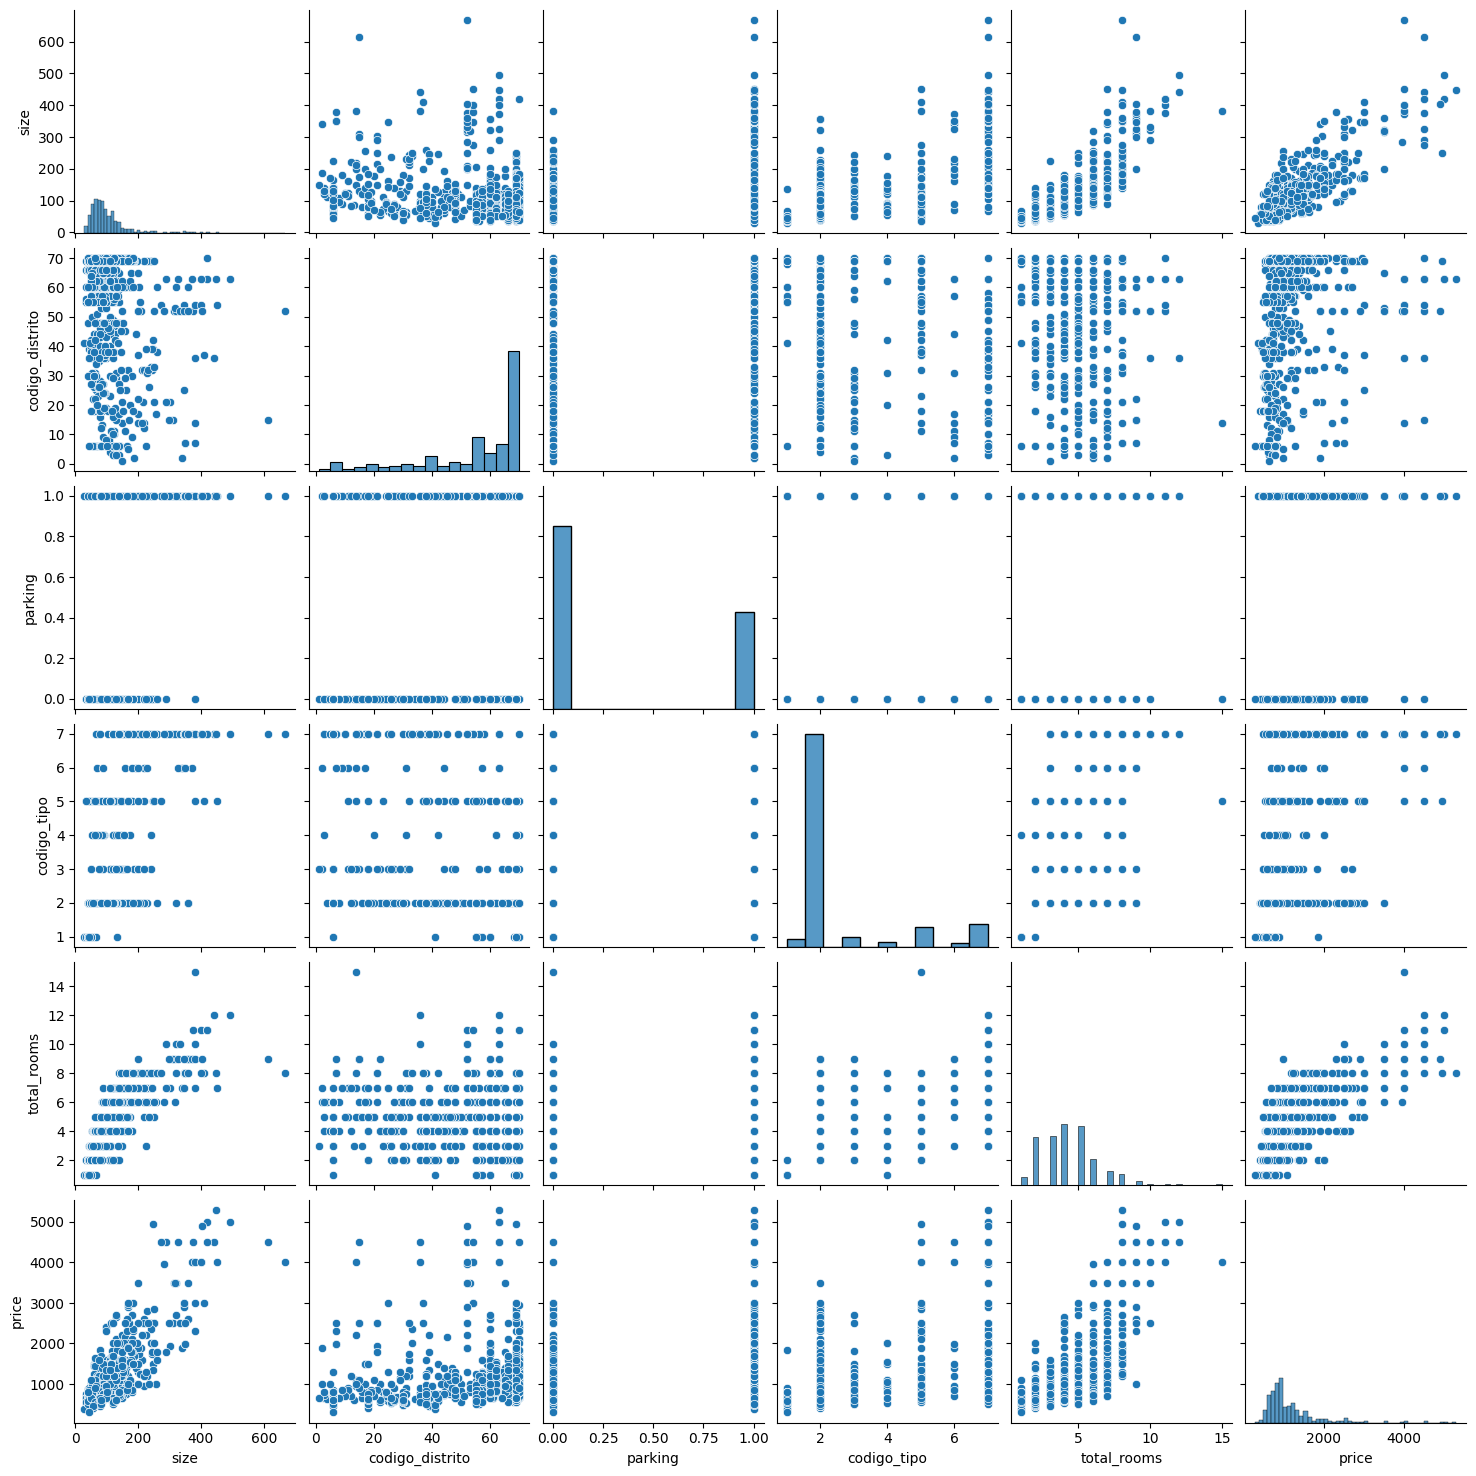

In [28]:
plt.figure(figsize=(8,8))
sns.pairplot(df_num)

Cosas que observamos en este pairplot:
- Efectivamente, se observa correlación entre size y total_rooms, ya que a mas tamaño, mas habitaciones y baños tendremos
- Se observa que, la viviendas con parking, son ligeramente mas caras que las viviendas sin parking
- A priori, el codigo_distrito, parece no tener correlación, ya que en cada distrito, hay viviendas de todo tipo, pero nos servirá para aproximarnos al precio según la localización de la vivienda.
- La distribucíon del código_distrito, se aprecia volcada a la derecha ya que la mayoria de zonas donde se alquilan pisos, son zonas centricas y por lo tanto mas caras son(centro, nervión, etc.)


In [30]:
from sklearn.model_selection import train_test_split

In [33]:
'''Una vez he terminado con el feature engineering,
divido la dataframe final en train y test entrenar y evaluar mi modelo.'''

df_train, df_test = train_test_split(df_num,test_size=0.15,random_state=10)

In [36]:
df.to_csv('data/df.csv', index=False)
df_num.to_csv('data/df_num.csv', index=False)
df_train.to_csv('data/df_train.csv', index=False)
df_test.to_csv('data/df_test.csv', index=False)